In [1]:
######## Loading training data and defining the generator ########

#Loading training data
import csv
import cv2
import numpy as np
import sklearn

#Loading sample training data

lines = [] 
with open('simulator_images/sim_images_log.csv') as csvfile:
    #next(csvfile) #skipping header row
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

from sklearn.utils import shuffle
lines = shuffle(lines)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                
                image = cv2.imread('simulator_images/' + batch_sample[0])
                #image_left = cv2.imread('sample_training_data/data/IMG/' + batch_sample[1].split('/')[-1])
                #image_right = cv2.imread('sample_training_data/data/IMG/' + batch_sample[2].split('/')[-1]) 
                images.append(image)
                #images.append(image_left)
                #images.append(image_right)
    
                steering_correction = 0.245
        
                measurement = int(batch_sample[2])
                #measurement_left = measurement_center + steering_correction
                #measurement_right = measurement_center - steering_correction
                measurements.append(measurement)
                #measurements.append(measurement_left)
                #measurements.append(measurement_right)
                
                #Flipping images
                #images.append(cv2.flip(image_center,1))
                #images.append(cv2.flip(image_left,1))
                #images.append(cv2.flip(image_right,1))
                #measurements.append(measurement_center*-1.0)
                #measurements.append(measurement_left*-1.0)
                #measurements.append(measurement_right*-1.0)

            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

print("Data loading generator defined!")
print("Number of image files:", len(lines))

#print("Shape of y_train:", y_train.shape)

Data loading generator defined!
Number of image files: 5153


OpenCV Version : 3.4.0 


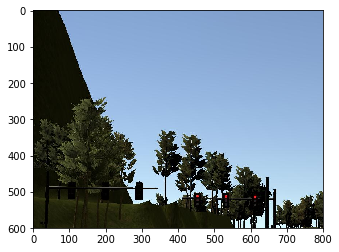

TL state: 0
Image size: (600, 800, 3)


In [5]:
######## Some sanity checks #########
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time as t

print ("OpenCV Version : %s " % cv2.__version__)

img = cv2.imread('simulator_images/' + lines[0][0])

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

measurement = int(lines[0][2])
print("TL state:", measurement)

print("Image size:", img.shape)

In [6]:
######## Definition of model archiecture & training ########

# Importing all necessary Keras modules
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.regularizers import l2
from keras.layers.advanced_activations import ELU

#define a lambda function for resizing images:
def myLambda(x):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(x, (60, 80))

# my model architecture
model = Sequential()
model.add(Lambda(myLambda, input_shape=(600, 800, 3))) # resizing images
#model.add(Cropping2D(cropping=((9,3), (0,0)))) #cropping images
model.add(Lambda(lambda x: (x / 255.0) - 0.5)) # normalizing data
model.add(Convolution2D(32, 5, 5))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.75))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.75))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile and train the model

model.compile(loss='binary_crossentropy', optimizer ='rmsprop', metrics=['accuracy'])

model.fit_generator(train_generator,
                    samples_per_epoch = (len(train_samples)//32)*32+32,
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=2, verbose=1)

model.save('model_v01.h5')

print("Model trained and saved")

Using TensorFlow backend.
C:\Users\tomek\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5))`
C:\Users\tomek\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\tomek\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\tomek\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `fit_generator` call to the Keras 2 API:

Epoch 1/2
4128/4128 [==============================] - 2501s 606ms/step - loss: 0.0298 - acc: 0.9904 - val_loss: 0.0275 - val_acc: 0.9971
Epoch 2/2
4128/4128 [==============================] - 2497s 605ms/step - loss: 0.0082 - acc: 0.9984 - val_loss: 0.0800 - val_acc: 0.9932
Model trained and saved
